# March Machine Learning Madness 2024: Modeling
### Predicting NCAA Basketball Tournament Results
##### From the [Kaggle Competition: "March Machine Learning Mania 2024"](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/overview)
##### By David Hartsman

### Overview:
In the previous notebook, I prepared data by selecting elements from over 30 different file sources. In this notebook, I will use that data to begin training models with the purpose of correctly predicting NCAA Tournament games. I have created 4 different target values:
- Binary W/L Target
- Continuous Team_A Pts Scored
- Continuous Team_B Pts Scored
- Continuous Team_A - Team_B Pts Differential

I will begin this notebook by attempting to build a successful classification model using algorithms from the Scikit-Learn Library. Depending on those results, I may move on and attempt to develop accurate Linear Regression models as well. 

<hr style="border: 4px solid blue">

In [228]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore")

# Sklearn Accessories
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, auc, roc_curve, \
roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector

# Model Types
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier,\
GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from classification_classes import Model, compare_curves

import xgboost
from xgboost import XGBClassifier


pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")

ImportError: cannot import name 'compare_curves' from 'classification_classes' (/Users/samalainabayeva/Documents/Flatiron/March_Machine_Learning_Madness/March_Machine_Learning_Mania_2024/classification_classes.py)

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Model Creation:</b> Final Feature Curation
</div>
After loading in the data, I will take a few final steps to prepare the data for modeling. I will select the features that I would like to use. As a starting point, I will opt to use as many features as possible, and subsequently weed out any features that may not be contributing much signal. 

I will also be creating "dummy" predictions. These predictions will be created by:

- A.) Choosing the lower of the 2 "Chalk_Seeds" as the winner, and
- B.) If the seeds are the same, choosing the team with the better winning percentage

These predictions are equivalent to picking *"chalk"*, or the on-paper favorite in every match-up without the benefit of any additional analysis. 

After that, I will perform a train-test split and create an sklearn pipeline to handle pre-modeling transformations such as *scaling* and *one-hot-encoding*. Then, utilize a class-object that I have created to store the results and metrics of different model iterations. 

In [2]:
# Load in data

# Create a path reference for easier readability 
path = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/NCAA_KAGGLE/march-machine-learning-mania-2024/'

# Load and inspect the data
df = pd.read_csv(os.path.join(path, 'Data_For_Modeling.csv'), index_col=0)
df.head()

,DayNum,League,Season,Team_A_Avg3ptAtt,Team_A_Avg3ptMade,Team_A_AvgFGAtt,Team_A_AvgFGMade,Team_A_AvgOppScore,Team_A_AvgPtDiff,Team_A_AvgTeamScore,Team_A_Avg_Assts,Team_A_Avg_Blocks,Team_A_Avg_Def_Rebs,Team_A_Avg_FT_Att,Team_A_Avg_FT_Made,Team_A_Avg_Fouls,Team_A_Avg_Off_Rebs,Team_A_Avg_Steals,Team_A_Avg_TO,Team_A_BestRanking,Team_A_Chalk_Seed,Team_A_CloseGames,Team_A_CloseWins,Team_A_Coach,Team_A_Conference,Team_A_DiffTrend,Team_A_HomeLoss,Team_A_HomeWins,Team_A_LastFivePtDiff,Team_A_LastFiveWinPerc,Team_A_LastTenPtDiff,Team_A_LastTenWinPerc,Team_A_Loc,Team_A_Loss_Total,Team_A_MaxLStreak,Team_A_MaxWStreak,Team_A_MedPtDiff,Team_A_MedianRanking,Team_A_NeutralLoss,Team_A_NeutralWins,Team_A_OTLoss,Team_A_OTWins,Team_A_OppAvg3ptAtt,Team_A_OppAvg3ptMade,Team_A_OppAvgFGAtt,Team_A_OppAvgFGMade,Team_A_OppAvg_Assts,Team_A_OppAvg_Blocks,Team_A_OppAvg_Def_Rebs,Team_A_OppAvg_FT_Att,Team_A_OppAvg_FT_Made,Team_A_OppAvg_Fouls,Team_A_OppAvg_Off_Rebs,Team_A_OppAvg_Steals,Team_A_OppAvg_TO,Team_A_OppTotal3ptAtt,Team_A_OppTotal3ptMade,Team_A_OppTotalFGAtt,Team_A_OppTotalFGMade,Team_A_OppTotal_Assts,Team_A_OppTotal_Def_Rebs,Team_A_OppTotal_FT_Att,Team_A_OppTotal_FT_Made,Team_A_OppTotal_Off_Rebs,Team_A_OppTotal_TO,Team_A_Relative_Diff_Trend,Team_A_Relative_Win_Trend,Team_A_RoadLoss,Team_A_RoadWins,Team_A_Score,Team_A_Seed,Team_A_StdDevOppScore,Team_A_StdDevTeamScore,Team_A_StdPtDiff,Team_A_TeamID,Team_A_Total3ptAtt,Team_A_Total3ptMade,Team_A_TotalFGAtt,Team_A_TotalFGMade,Team_A_Total_Assts,Team_A_Total_Def_Rebs,Team_A_Total_FT_Att,Team_A_Total_FT_Made,Team_A_Total_Off_Rebs,Team_A_Total_TO,Team_A_WinTrend,Team_A_Win_Total,Team_A_WorstRanking,Team_A_close_game_win_perc,Team_A_home_win_perc,Team_A_neutral_win_perc,Team_A_ot_win_perc,Team_A_road_win_perc,Team_A_win_perc,Team_B_Avg3ptAtt,Team_B_Avg3ptMade,Team_B_AvgFGAtt,Team_B_AvgFGMade,Team_B_AvgOppScore,Team_B_AvgPtDiff,Team_B_AvgTeamScore,Team_B_Avg_Assts,Team_B_Avg_Blocks,Team_B_Avg_Def_Rebs,Team_B_Avg_FT_Att,Team_B_Avg_FT_Made,Team_B_Avg_Fouls,Team_B_Avg_Off_Rebs,Team_B_Avg_Steals,Team_B_Avg_TO,Team_B_BestRanking,Team_B_Chalk_Seed,Team_B_CloseGames,Team_B_CloseWins,Team_B_Coach,Team_B_Conference,Team_B_DiffTrend,Team_B_HomeLoss,Team_B_HomeWins,Team_B_LastFivePtDiff,Team_B_LastFiveWinPerc,Team_B_LastTenPtDiff,Team_B_LastTenWinPerc,Team_B_Loc,Team_B_Loss_Total,Team_B_MaxLStreak,Team_B_MaxWStreak,Team_B_MedPtDiff,Team_B_MedianRanking,Team_B_NeutralLoss,Team_B_NeutralWins,Team_B_OTLoss,Team_B_OTWins,Team_B_OppAvg3ptAtt,Team_B_OppAvg3ptMade,Team_B_OppAvgFGAtt,Team_B_OppAvgFGMade,Team_B_OppAvg_Assts,Team_B_OppAvg_Blocks,Team_B_OppAvg_Def_Rebs,Team_B_OppAvg_FT_Att,Team_B_OppAvg_FT_Made,Team_B_OppAvg_Fouls,Team_B_OppAvg_Off_Rebs,Team_B_OppAvg_Steals,Team_B_OppAvg_TO,Team_B_OppTotal3ptAtt,Team_B_OppTotal3ptMade,Team_B_OppTotalFGAtt,Team_B_OppTotalFGMade,Team_B_OppTotal_Assts,Team_B_OppTotal_Def_Rebs,Team_B_OppTotal_FT_Att,Team_B_OppTotal_FT_Made,Team_B_OppTotal_Off_Rebs,Team_B_OppTotal_TO,Team_B_Relative_Diff_Trend,Team_B_Relative_Win_Trend,Team_B_RoadLoss,Team_B_RoadWins,Team_B_Score,Team_B_Seed,Team_B_StdDevOppScore,Team_B_StdDevTeamScore,Team_B_StdPtDiff,Team_B_TeamID,Team_B_Total3ptAtt,Team_B_Total3ptMade,Team_B_TotalFGAtt,Team_B_TotalFGMade,Team_B_Total_Assts,Team_B_Total_Def_Rebs,Team_B_Total_FT_Att,Team_B_Total_FT_Made,Team_B_Total_Off_Rebs,Team_B_Total_TO,Team_B_WinTrend,Team_B_Win_Total,Team_B_WorstRanking,Team_B_close_game_win_perc,Team_B_home_win_perc,Team_B_neutral_win_perc,Team_B_ot_win_perc,Team_B_road_win_perc,Team_B_win_perc,Team_A_Win,Game_Point_Differential
1136,134,Men,2003,18.500000,5.933333,55.266667,24.733333,70.833333,1.966667,72.800000,14.200000,2.233333,24.800000,28.066667,17.400000,18.300000,13.166667,6.433333,15.233333,233.0,16.0,14.0,9.0,NaN,swac,Uptrend,3.0,11.0,7.2,0.570331,0.5,0.568849,N,12.0,6.0,8.0,2.5,259.0,1.0,3.0,0.0,1.0,23.166667,7.533333,60.400000,25.666667,13.766667,2.600000,22.866667,18.733333,11.966667,21.633333,11.933333,8.000000,14.333333,695.0,226.0,1812.0,770.0,41

In [95]:
df.shape

(2583, 188)

<hr style="border: 2px solid blue">

### Creating Dummy Predictions

In [3]:
# Inspecting the criteria for generating dummy predictions 

df[["Team_A_Chalk_Seed", 'Team_B_Chalk_Seed', "Team_A_win_perc", 'Team_B_win_perc']].head()

,Team_A_Chalk_Seed,Team_B_Chalk_Seed,Team_A_win_perc,Team_B_win_perc
1136,16.0,16.0,0.600000,0.448276
1137,1.0,16.0,0.892857,0.655172
1138,10.0,7.0,0.620690,0.793103
1139,6.0,11.0,0.878788,0.793103
1140,9.0,8.0,0.600000,0.724138


In [4]:
# Function to get dummy predictions

def get_dummy_preds(data):

    # Create a container
    dummy_preds = []

    # Loop through the dataframe based on conditions
    for idx, row in data.iterrows():
        if data.loc[idx, "Team_A_Chalk_Seed"] < data.loc[idx, "Team_B_Chalk_Seed"]:
            dummy_preds.append(1)
        elif data.loc[idx, "Team_A_Chalk_Seed"] > data.loc[idx, "Team_B_Chalk_Seed"]:
            dummy_preds.append(0)
        else:
            if data.loc[idx, "Team_A_win_perc"] > data.loc[idx, "Team_B_win_perc"]:
                dummy_preds.append(1)
            else:
                dummy_preds.append(0)
    
    return np.array(dummy_preds)


# Assignment
df["Dummy_Predictions"] = get_dummy_preds(df)

# Inspection
df[["Team_A_Chalk_Seed", 'Team_B_Chalk_Seed', "Team_A_win_perc", 'Team_B_win_perc', "Dummy_Predictions"]].head()

,Team_A_Chalk_Seed,Team_B_Chalk_Seed,Team_A_win_perc,Team_B_win_perc,Dummy_Predictions
1136,16.0,16.0,0.600000,0.448276,1
1137,1.0,16.0,0.892857,0.655172,1
1138,10.0,7.0,0.620690,0.793103,0
1139,6.0,11.0,0.878788,0.793103,1
1140,9.0,8.0,0.600000,0.724138,0


<hr style="border: 2px solid blue">

### Selecting Features for Modeling
Currently, the data has 188 different columns, but several of those columns are targets, or redundant aggregated statistics. Also, due to the variety of different sources, a huge amount of rows contain null or missing value, and they are outside the typically advised number of rows to drop without sacrificing data integrity. Still, in lieu of better alternatives, I will drop them for the time being. I will still attempt to include as many rows and features as possible. 

There are 441 missing/null values in much of the data, all of which are from the **WOMEN'S DATA**. This amounts to 17.1% of the overall data. Unfortunately, it will have to be dropped. 

In [114]:
# Demonstration
df[df["Team_A_AvgFGAtt"].isna()]["League"].value_counts()

League
Women    441
Name: count, dtype: int64

In [5]:
# For demonstration purposes showing consistency of null counts

df[["Team_A_AvgFGAtt", 'Team_A_AvgPtDiff', "Team_A_Avg_Blocks"]].isna().sum()

Team_A_AvgFGAtt      441
Team_A_AvgPtDiff     441
Team_A_Avg_Blocks    441
dtype: int64

In [103]:
common_nulls = []
tons_of_nulls = []
normal_nulls = []
for col in df.columns:
    if df[col].isna().sum() == 441:
        common_nulls.append(col)
    elif df[col].isna().sum() > 441:
        tons_of_nulls.append(col)
    else:
        normal_nulls.append(col)
len(common_nulls), len(tons_of_nulls), len(normal_nulls)

(160, 16, 12)

In [104]:
tons_of_nulls

['Team_A_BestRanking',
 'Team_A_Coach',
 'Team_A_MedianRanking',
 'Team_A_WorstRanking',
 'Team_A_close_game_win_perc',
 'Team_A_home_win_perc',
 'Team_A_neutral_win_perc',
 'Team_A_ot_win_perc',
 'Team_B_BestRanking',
 'Team_B_Coach',
 'Team_B_MedianRanking',
 'Team_B_WorstRanking',
 'Team_B_close_game_win_perc',
 'Team_B_home_win_perc',
 'Team_B_neutral_win_perc',
 'Team_B_ot_win_perc']

In [110]:
df[df["Team_A_MedianRanking"].notna()]

League
Men    1305
Name: count, dtype: int64

In [101]:
df.drop(columns=common_nulls).columns

Index(['DayNum', 'League', 'Season', 'Team_A_BestRanking', 'Team_A_Coach',
       'Team_A_Loc', 'Team_A_MedianRanking', 'Team_A_Score', 'Team_A_TeamID',
       'Team_A_WorstRanking', 'Team_A_close_game_win_perc',
       'Team_A_home_win_perc', 'Team_A_neutral_win_perc', 'Team_A_ot_win_perc',
       'Team_B_BestRanking', 'Team_B_Coach', 'Team_B_Loc',
       'Team_B_MedianRanking', 'Team_B_Score', 'Team_B_TeamID',
       'Team_B_WorstRanking', 'Team_B_close_game_win_perc',
       'Team_B_home_win_perc', 'Team_B_neutral_win_perc', 'Team_B_ot_win_perc',
       'Team_A_Win', 'Game_Point_Differential', 'Dummy_Predictions'],
      dtype='object')

In [6]:
# Dropping the 441 rows from all columns - Avg3ptAtt is a representative column as many columns have 441 nulls

dropped = df.dropna(subset=["Team_A_Avg3ptAtt"]).copy()

The majority of the remaining null values fall in to two different categories. Columns containing ranking data from the Massey file in the previous notebook, as this information was only available for men after a certain year. This ranking data will be dropped from our modeling for the time being. The remaining nulls mostly stem from zero-division issues for teams having 0 close games, overtime games, etc. Those values can be more easily imputed. 

I will be dropping the following features:

- DayNum as it does not provide any team-specific data
- Season as it was only used for joining data and shouldn't contain any signal
- Ranking Columns 
- Coach as once again it was only available for men
- Most Columns Containing Season Totals as opposed to averages

In [7]:
# Dropping these features, target columns are still included for the time being

columns_to_drop = ['DayNum', "Season", 'Team_A_BestRanking', 'Team_A_Coach', "Team_A_DiffTrend", \
                   "Team_A_MedianRanking", 'Team_A_TeamID', 'Team_A_Total3ptAtt', 'Team_A_Total3ptMade', \
                   'Team_A_TotalFGAtt', 'Team_A_TotalFGMade', 'Team_A_Total_Assts', 'Team_A_Total_Def_Rebs', \
                   'Team_A_Total_FT_Att', 'Team_A_Total_FT_Made', 'Team_A_Total_Off_Rebs', 'Team_A_Total_TO', \
                   'Team_A_WinTrend', 'Team_A_WorstRanking', 'Team_A_Seed', \
                  'Team_B_BestRanking', 'Team_B_Coach', "Team_B_DiffTrend", \
                   "Team_B_MedianRanking", 'Team_B_TeamID', 'Team_B_Total3ptAtt', 'Team_B_Total3ptMade', \
                   'Team_B_TotalFGAtt', 'Team_B_TotalFGMade', 'Team_B_Total_Assts', 'Team_B_Total_Def_Rebs', \
                   'Team_B_Total_FT_Att', 'Team_B_Total_FT_Made', 'Team_B_Total_Off_Rebs', 'Team_B_Total_TO', \
                   'Team_B_WinTrend', 'Team_B_WorstRanking', 'Team_B_Seed']

print(f"Dropping {len(columns_to_drop)} features")

Dropping 38 features


In [8]:
# Re-assigning the variable
dropped = dropped.drop(columns=columns_to_drop)

In [9]:
# These columns have categorical information

object_columns = ["League", 'Team_A_Conference', 'Team_A_Loc', 'Team_A_Relative_Diff_Trend', \
                  'Team_A_Relative_Win_Trend',\
                  'Team_B_Conference', 'Team_B_Loc', 'Team_B_Relative_Diff_Trend', 'Team_B_Relative_Win_Trend']

# Changing the dtype
for i in object_columns:
    dropped[i] = dropped[i].astype("category")
    
    
# Inspecting the new dtypes
dropped[object_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2142 entries, 1136 to 4033
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   League                      2142 non-null   category
 1   Team_A_Conference           2142 non-null   category
 2   Team_A_Loc                  2142 non-null   category
 3   Team_A_Relative_Diff_Trend  2142 non-null   category
 4   Team_A_Relative_Win_Trend   2142 non-null   category
 5   Team_B_Conference           2142 non-null   category
 6   Team_B_Loc                  2142 non-null   category
 7   Team_B_Relative_Diff_Trend  2142 non-null   category
 8   Team_B_Relative_Win_Trend   2142 non-null   category
dtypes: category(9)
memory usage: 39.1 KB


<hr style="border: 2px solid blue">

### D-type Breakdown:
There are 150 columns remaining at this point. 145 of those are actually features.

- 9 columns are objects/categories
- 136 are currently saved as float64, 9 + 136 = 145
- The remaining 5 columns are the 4 target values and 1 dummy predictions

**Now......** I have the data and features selected, and I will begin the final preparation for modeling. This will include assigning X and y variables, conducting a train test split, and instantiating sklearn pipelines to handle data transformations. 

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Model Creation:</b> Final Pre-Processing
</div>

### Splitting Data

In [10]:
# Assigning X and y variables, train-test split

# Features
X = dropped.drop(columns=["Team_A_Score", "Team_B_Score", "Team_A_Win", 'Game_Point_Differential', \
                          "Dummy_Predictions"])

# Target
y = dropped["Team_A_Win"]

# Train-test split, 25% Test Size
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=.25, shuffle=True, stratify=y)

In [11]:
# Creating Pipeline objects

numeric_pipe = Pipeline(steps=[
    ("si", SimpleImputer(add_indicator=True, strategy="median")),
    ("mms", MinMaxScaler())
])

cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

ct = ColumnTransformer(transformers=[
    ("num_pipe", numeric_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])


pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', LogisticRegression())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f922b0fd4e0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f922b0fd4b0>)])),
                ('model', LogisticRegression())])

In [12]:
# First Model Creation

logistic_1 = Model("Baseline Logistic Regression", pipe_model, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer t

In [13]:
# Dummy logic Test Predictions - if at any point I use a different random_state, i can call this to update stats
 
def dummy_pred_df_entry(train_preds=get_dummy_preds(X_train), test_preds=get_dummy_preds(X_test)):
    dummy_dict = {
        "name":"Dummy Selection Logic", 
         "train_accuracy": accuracy_score(y_train, train_preds),  # train metrics 
         "train_prec": precision_score(y_train, train_preds),
         "train_recall": recall_score(y_train, train_preds),
         "train_f1": f1_score(y_train, train_preds),
         "train_logloss": log_loss(y_train, train_preds), 
         "test_accuracy":accuracy_score(y_test, test_preds), # test metrics
         "test_prec": precision_score(y_test, test_preds),
         "test_recall": recall_score(y_test, test_preds),
         "test_f1":f1_score(y_test, test_preds),
         "test_logloss":log_loss(y_test, test_preds)}
    return dummy_dict

In [14]:
# Data for the first model iteration:

# Add dummy data
Model.model_df.loc[1] = dummy_pred_df_entry()

# Inspect overall model
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.53054,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.56077,0.716418,0.705263,0.747212,0.725632,10.221335,NaN


<hr style="border: 2px solid blue">

### Class and Functions to Extract Coefficients or Feature Importances
I want to leave this definition inside the notebook because its features will be changing as I go through the process of modeling.

In [51]:
# Class for collecting coefficients of models based on economic features

class Importance():
    
    global pipe_model
    df = pd.DataFrame(columns=list(pipe_model.get_params()["ct"].get_feature_names_out()))
    df.columns = [i.replace("num_pipe__", "").replace("cat_pipe__", "") for i in df.columns]
    
    # Init method
    def __init__(self, coefs):
        self.dict = coefs
    
        # Add the metrics to the class dataframe
        idx = len(Importance.df)
        Importance.df.loc[idx] = self.dict
    
    
    def add_coefs(self, coefs):
        idx = len(Importance.df)
        Importance.df.loc[idx] = coefs
        
    
    def __str__(self):
      return "Feature Importance/Coefficient DataFrame"


# Functions to aid in collection

# Extract Feature Importance from Tree-based Models

def features_from_trees(model_class, number_of_features=5):
    """
    Extracts and zips feature importances with their feature names for tree-based models like Random Forest,
    Extra Trees, and XGBoost
    
    Parameters
    ------------
    model_class: variable name of class Model instance | 
        i.e. rfc = Model("Random Forest Class") ->   <rfc> would be the desired model_class argument
    
    number_of_features: int| number of features desired as output of print() side-effect, no bearing on return value
    
    Returns:
    -----------
    sorted list: a list of tuples sorted by the "feature_importance" value (feature_name, importance)
    """

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    idx = len(Importance.df)
    Importance(imp_dict)
    Importance.df.rename(index={idx:model_class.name}, inplace=True)
    

    print(f"Top {number_of_features} Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:number_of_features]:
        print(i)
    
    return sorted(imp_list, key=lambda x: x[1], reverse=True)
        


# Extracts the coefficients from Logistic Regression models and pairs them with their features

def coefs_from_lr(model_class, number_of_coefs=5):
    
    """
    Extracts and zips feature coefficients with their feature names for parametric models like Logistic Regression
    
    Parameters
    ------------
    model_class: variable name of class Model instance | 
        i.e. logreg = Model("Logistic Regression") ->   <logreg> would be the desired model_class argument
    
    number_of_features: int| number of features desired as output of print() side-effect, no bearing on return value
    
    Returns:
    -----------
    sorted list: a list of tuples sorted by the absolute value of the "coefficient" value 
        (feature_name, coefficient)
    """
    
    features = model_class.model.named_steps["ct"].get_feature_names_out()
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]
    
    coef_feats = model_class.model.get_params()['model'].coef_[0]
    
    imp_list = list(zip(features_list, coef_feats))
    imp_dict = dict(imp_list)
    
    idx = len(Importance.df)
    Importance(imp_dict)
    Importance.df.rename(index={idx:model_class.name}, inplace=True)

    print(f"Top {number_of_coefs} Feature Coefficients by Absolute Value")
    for i in sorted(imp_list, key=lambda x: np.abs(x[1]), reverse=True)[:number_of_coefs]:
        print(i)
    
    return sorted(imp_list, key=lambda x: np.abs(x[1]), reverse=True)


def get_polarized_magnitudes(num_of_features, model_name):
    """
    Function to display "num_of_features" number of largest and smallest coefficients or feature importances
    
    Parameters:
    -------------
    num_of_features: int | number of large/small coefficients/features returned
    model_name: str | string name of model stored in Model.name for the custom model class
    
    Returns:
    -------------
    combined: concatenated df with one row as a partition between the largest and smallest values
    """
    # Sort and select top features
    global Importance
    top_features_high = Importance.df.T.sort_values(by=model_name, ascending=False)[:num_of_features]
    top_features_low = Importance.df.T.sort_values(by=model_name, ascending=True)[:num_of_features]
    
    # Create an empty DataFrames with 999999 values
    empty_row = pd.DataFrame([[99999] * len(top_features_high.columns)], columns=top_features_high.columns)
    empty_row.rename(index={0:"PARTITION Large Above|Small Below"}, inplace=True)
    empty_row_2 = pd.DataFrame([[99999] * len(top_features_high.columns)], columns=top_features_high.columns)
    empty_row_2.rename(index={0:"PARTITION Large Above|Small Below"}, inplace=True)
    # Concatenate DataFrames with an empty row in between
    combined = pd.concat([top_features_high, empty_row, empty_row_2, top_features_low], axis=0)
    
    return combined


def get_largest_magnitudes(num_of_features, extracted_features_list):
    """
    Function to display "num_of_features" number of largest magnitude coefficients or feature importances
    
    Parameters:
    -------------
    num_of_features: int | number of large/small coefficients/features returned
    model_name: str | string name of model stored in Model.name for the custom model class
    
    Returns:
    -------------
    combined: concatenated df with one row as a partition between the largest and smallest values
    """
    # Create DataFrame from list of tuples
    data = pd.DataFrame(extracted_features_list[:num_of_features])
    data.rename(columns={0:"Feature Name", 1:"Coef/Importance"}, inplace=True)
    return data

<hr style="border: 2px solid blue">

In [52]:
# Extracting the coefficient values of the model
logreg_coef = coefs_from_lr(logistic_1, 20)

Top 20 Feature Coefficients by Absolute Value
('Team_B_Chalk_Seed', 2.204177963957876)
('Team_A_Chalk_Seed', -1.9596564804475771)
('Team_A_Avg_Blocks', 1.3214986388136671)
('Team_B_Avg_FT_Att', 1.1218521914384205)
('Team_A_OppAvg_Def_Rebs', -0.9453435179365078)
('missingindicator_Team_A_neutral_win_perc', -0.9034837612784214)
('Team_B_AvgFGMade', -0.8575103352067229)
('Team_A_OppTotal_TO', 0.8460844439998738)
('Team_B_AvgPtDiff', -0.8030972080422378)
('Team_A_Avg_Def_Rebs', -0.7797466966230125)
('Team_A_LastFivePtDiff', -0.7550556215710919)
('Team_A_AvgFGMade', 0.7502056222700226)
('Team_B_OppAvg_Def_Rebs', 0.7434198692376042)
('Team_A_close_game_win_perc', -0.710330332757669)
('Team_B_AvgTeamScore', -0.7075940792473261)
('Team_B_LastTenWinPerc', -0.674712852579036)
('Team_A_OppAvg_FT_Att', -0.6596901185313329)
('Team_A_AvgTeamScore', 0.6407673822894853)
('Team_A_AvgPtDiff', 0.6374009159285827)
('Team_B_OppAvg_Assts', 0.6269364198648412)


In [53]:
# First Function
get_polarized_magnitudes(7, "Baseline Logistic Regression")

,Baseline Logistic Regression
Team_B_Chalk_Seed,2.204178
Team_A_Avg_Blocks,1.321499
Team_B_Avg_FT_Att,1.121852
Team_A_OppTotal_TO,0.846084
Team_A_AvgFGMade,0.750206
Team_B_OppAvg_Def_Rebs,0.743420
Team_A_AvgTeamScore,0.640767
PARTITION Large Above|Small Below,99999.000000
PARTITION Large Above|Small Below,99999.000000
Team_A_Chalk_Seed,-1.959656


In [54]:
# Same idea but sorted by magnitude

get_largest_magnitudes(10, logreg_coef)

,Feature Name,Coef/Importance
0,Team_B_Chalk_Seed,2.204178
1,Team_A_Chalk_Seed,-1.959656
2,Team_A_Avg_Blocks,1.321499
3,Team_B_Avg_FT_Att,1.121852
4,Team_A_OppAvg_Def_Rebs,-0.945344
5,missingindicator_Team_A_neutral_win_perc,-0.903484
6,Team_B_AvgFGMade,-0.857510
7,Team_A_OppTotal_TO,0.846084
8,Team_B_AvgPtDiff,-0.803097
9,Team_A_Avg_Def_Rebs,-0.779747


In [55]:
# Full List of Coefficients

Importance.df.T

,Baseline Logistic Regression
Team_A_Avg3ptAtt,0.225952
Team_A_Avg3ptMade,0.088628
Team_A_AvgFGAtt,0.223829
Team_A_AvgFGMade,0.750206
Team_A_AvgOppScore,-0.228961
...,...
missingindicator_Team_A_ot_win_perc,0.046726
missingindicator_Team_B_close_game_win_perc,-0.348976
missingindicator_Team_B_home_win_perc,-0.210759
missingindicator_Team_B_neutral_win_perc,0.007224


<hr style="border: 2px solid blue">

### Observations on the First Model:

Unfortunately, the Logistic Regression model with default hyperparameters failed to outperform predictions made solely based on "Chalk_Seed" and "Win_Pct". The features with the two largest magnitude coefficients made total sense: Seeds. The other largest coefficients were a mixture of different statistics. Hopefully, different model types may prove more successful at predicting outcomes. 

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Additional Model Iterations:</b>
</div>
Next, I will fit different types of models to the data and compare the accuracy of these models to our baseline Logistic Regression and dummy model.

In [41]:
# Fitting a RandomForestClassifier

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', XGBClassifier())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f922b0fd4e0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [56]:
# Instantiation and saving data to the class

# Default Random Forest Classifier - 3rd best, but far off of standard
# random_forest = Model("Random Forest Classifier", pipe_model, X_train, X_test, y_train, y_test)

# Extra Trees Classifier - still significantly worse
# extra_trees = Model("Extra Trees Classifier", pipe_model, X_train, X_test, y_train, y_test)

# KNN Classifier - worst out of 6
# knn = Model("KNN Classifier", pipe_model, X_train, X_test, y_train, y_test)

# XG Boost - middle of the pack
# xgb = Model("XGBoost Classifier", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df.sort_values("test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
2,Random Forest Classifier,0.704837,0.716483,0.687693,0.700684,0.553453,0.692164,0.685714,0.713755,0.699454,0.567078,0.775768
3,Extra Trees Classifier,0.714798,0.721213,0.708765,0.714220,0.550605,0.679104,0.671378,0.706320,0.688406,0.569795,0.769294
5,XGBoost Classifier,0.715425,0.728680,0.695100,0.710133,0.702211,0.679104,0.673835,0.698885,0.686131,0.837950,0.760787
4,KNN Classifier,0.657528,0.660910,0.656759,0.658195,1.388824,0.639925,0.643939,0.631970,0.637899,1.968196,0.688644


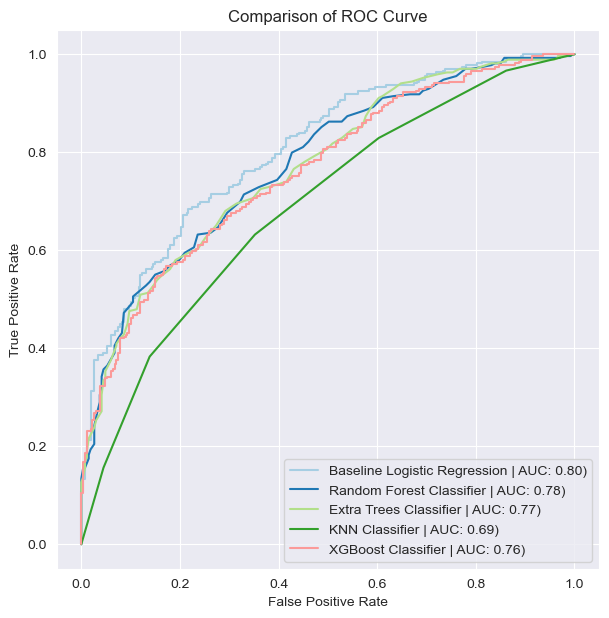

In [44]:
# Looking at ROC Curves to assess overall model performance
xgb.compare_roc_curve()
plt.grid(True)

In [59]:
# Extracting Feature Importances from Tree Models

# rfc_feat = features_from_trees(random_forest)
# etc_feat = features_from_trees(extra_trees)
# xgb_feat = features_from_trees(xgb)

Importance.df

,Team_A_Avg3ptAtt,Team_A_Avg3ptMade,Team_A_AvgFGAtt,Team_A_AvgFGMade,Team_A_AvgOppScore,Team_A_AvgPtDiff,Team_A_AvgTeamScore,Team_A_Avg_Assts,Team_A_Avg_Blocks,Team_A_Avg_Def_Rebs,Team_A_Avg_FT_Att,Team_A_Avg_FT_Made,Team_A_Avg_Fouls,Team_A_Avg_Off_Rebs,Team_A_Avg_Steals,Team_A_Avg_TO,Team_A_Chalk_Seed,Team_A_CloseGames,Team_A_CloseWins,Team_A_HomeLoss,Team_A_HomeWins,Team_A_LastFivePtDiff,Team_A_LastFiveWinPerc,Team_A_LastTenPtDiff,Team_A_LastTenWinPerc,Team_A_Loss_Total,Team_A_MaxLStreak,Team_A_MaxWStreak,Team_A_MedPtDiff,Team_A_NeutralLoss,Team_A_NeutralWins,Team_A_OTLoss,Team_A_OTWins,Team_A_OppAvg3ptAtt,Team_A_OppAvg3ptMade,Team_A_OppAvgFGAtt,Team_A_OppAvgFGMade,Team_A_OppAvg_Assts,Team_A_OppAvg_Blocks,Team_A_OppAvg_Def_Rebs,Team_A_OppAvg_FT_Att,Team_A_OppAvg_FT_Made,Team_A_OppAvg_Fouls,Team_A_OppAvg_Off_Rebs,Team_A_OppAvg_Steals,Team_A_OppAvg_TO,Team_A_OppTotal3ptAtt,Team_A_OppTotal3ptMade,Team_A_OppTotalFGAtt,Team_A_OppTotalFGMade,Team_A_OppTotal_Assts,Team_A_OppTotal_Def_Rebs,Team_A_OppTotal_FT_Att,Team_A_OppTotal_FT_Made,Team_A_OppTotal_Off_Rebs,Team_A_OppTotal_TO,Team_A_RoadLoss,Team_A_RoadWins,Team_A_StdDevOppScore,Team_A_StdDevTeamScore,Team_A_StdPtDiff,Team_A_Win_Total,Team_A_close_game_win_perc,Team_A_home_win_perc,Team_A_neutral_win_perc,Team_A_ot_win_perc,Team_A_road_win_perc,Team_A_win_perc,Team_B_Avg3ptAtt,Team_B_Avg3ptMade,Team_B_AvgFGAtt,Team_B_AvgFGMade,Team_B_AvgOppScore,Team_B_AvgPtDiff,Team_B_AvgTeamScore,Team_B_Avg_Assts,Team_B_Avg_Blocks,Team_B_Avg_Def_Rebs,Team_B_Avg_FT_Att,Team_B_Avg_FT_Made,Team_B_Avg_Fouls,Team_B_Avg_Off_Rebs,Team_B_Avg_Steals,Team_B_Avg_TO,Team_B_Chalk_Seed,Team_B_CloseGames,Team_B_CloseWins,Team_B_HomeLoss,Team_B_HomeWins,Team_B_LastFivePtDiff,Team_B_LastFiveWinPerc,Team_B_LastTenPtDiff,Team_B_LastTenWinPerc,Team_B_Loss_Total,Team_B_MaxLStreak,Team_B_MaxWStreak,Team_B_MedPtDiff,Team_B_NeutralLoss,Team_B_NeutralWins,Team_B_OTLoss,Team_B_OTWins,Team_B_OppAvg3ptAtt,Team_B_OppAvg3ptMade,Team_B_OppAvgFGAtt,Team_B_OppAvgFGMade,Team_B_OppAvg_Assts,Team_B_OppAvg_Blocks,Team_B_OppAvg_Def_Rebs,Team_B_OppAvg_FT_Att,Team_B_OppAvg_FT_Made,Team_B_OppAvg_Fouls,Team_B_OppAvg_Off_Rebs,Team_B_OppAvg_Steals,Team_B_OppAvg_TO,Team_B_OppTotal3ptAtt,Team_B_OppTotal3ptMade,Team_B_OppTotalFGAtt,Team_B_OppTotalFGMade,Team_B_OppTotal_Assts,Team_B_OppTotal_Def_Rebs,Team_B_OppTotal_FT_Att,Team_B_OppTotal_FT_Made,Team_B_OppTotal_Off_Rebs,Team_B_OppTotal_TO,Team_B_RoadLoss,Team_B_RoadWins,Team_B_StdDevOppScore,Team_B_StdDevTeamScore,Team_B_StdPtDiff,Team_B_Win_Total,Team_B_close_game_win_perc,Team_B_home_win_perc,Team_B_neutral_win_perc,Team_B_ot_win_perc,Team_B_road_win_perc,Team_B_win_perc,missingindicator_Team_A_close_game_win_perc,missingindicator_Team_A_home_win_perc,missingindicator_Team_A_neutral_win_perc,missingindicator_Team_A_ot_win_perc,missingindicator_Team_B_close_game_win_perc,missingindicator_Team_B_home_win_perc,missingindicator_Team_B_neutral_win_perc,missingindicator_Team_B_ot_win_perc
Baseline Logistic Regression,0.225952,0.088628,0.223829,0.750206,-0.228961,0.637401,0.640767,0.261619,1.321499,-0.779747,0.132728,0.003858,-0.356515,-0.048486,0.037132,-0.283606,-1.959656,0.109863,-0.080853,0.132631,0.156717,-0.755056,-0.352683,-0.447223,-0.394600,0.131736,-0.011977,0.370245,-0.064396,0.060430,0.189868,-0.218025,-0.064844,0.146813,-0.378717,0.001674,-0.276944,-0.108129,-0.013056,-0.945344,-0.659690,0.215983,-0.482475,-0.407308,-0.227351,0.435784,0.147324,-0.396221,0.427905,0.190190,0.164117,-0.171571,-0.466357,0.309962,0.039398,0.846084,0.074796,0.238170,-0.588126,-0.274784,0.608385,0.405711,-0.710330,0.111432,0.137371,-0.223490,0.573781,-0.161711,0.321314,-0.021214,-0.218538,-0.857510,0.349252,-0.803097,-0.707594,0.382983,-0.204950,-0.105482,1.121852,-0.036896,0.569705,-0.535131,-0.264348,0.294932,2.204178,0.385708,-0.231818,-0.480630,0.013843,-0.152546,-0.352630,0.059082,-0.674713,-0.286340,-0.117243,0.282191,-0.420201,-0.443234,-0.589267,-0.303976,0.299677,0.014839,0.182901,0.569851,0.33358

In [96]:
for i in [logreg_coef, rfc_feat, etc_feat, xgb_feat]:
    print(get_largest_magnitudes(20, i), "\n")

                                Feature Name  Coef/Importance
0                          Team_B_Chalk_Seed         2.204178
1                          Team_A_Chalk_Seed        -1.959656
2                          Team_A_Avg_Blocks         1.321499
3                          Team_B_Avg_FT_Att         1.121852
4                     Team_A_OppAvg_Def_Rebs        -0.945344
5   missingindicator_Team_A_neutral_win_perc        -0.903484
6                           Team_B_AvgFGMade        -0.857510
7                         Team_A_OppTotal_TO         0.846084
8                           Team_B_AvgPtDiff        -0.803097
9                        Team_A_Avg_Def_Rebs        -0.779747
10                     Team_A_LastFivePtDiff        -0.755056
11                          Team_A_AvgFGMade         0.750206
12                    Team_B_OppAvg_Def_Rebs         0.743420
13                Team_A_close_game_win_perc        -0.710330
14                       Team_B_AvgTeamScore        -0.707594
15      

In [65]:
get_largest_magnitudes(20, xgb_feat)

,Feature Name,Coef/Importance
0,Team_B_Chalk_Seed,0.049533
1,Team_A_Chalk_Seed,0.034929
2,Team_B_MedPtDiff,0.026930
3,Team_B_win_perc,0.020194
4,Team_B_Win_Total,0.016553
5,Team_A_RoadLoss,0.015946
6,Team_B_road_win_perc,0.015227
7,Team_B_AvgPtDiff,0.015120
8,Team_A_AvgPtDiff,0.013530
9,Team_A_win_perc,0.013281


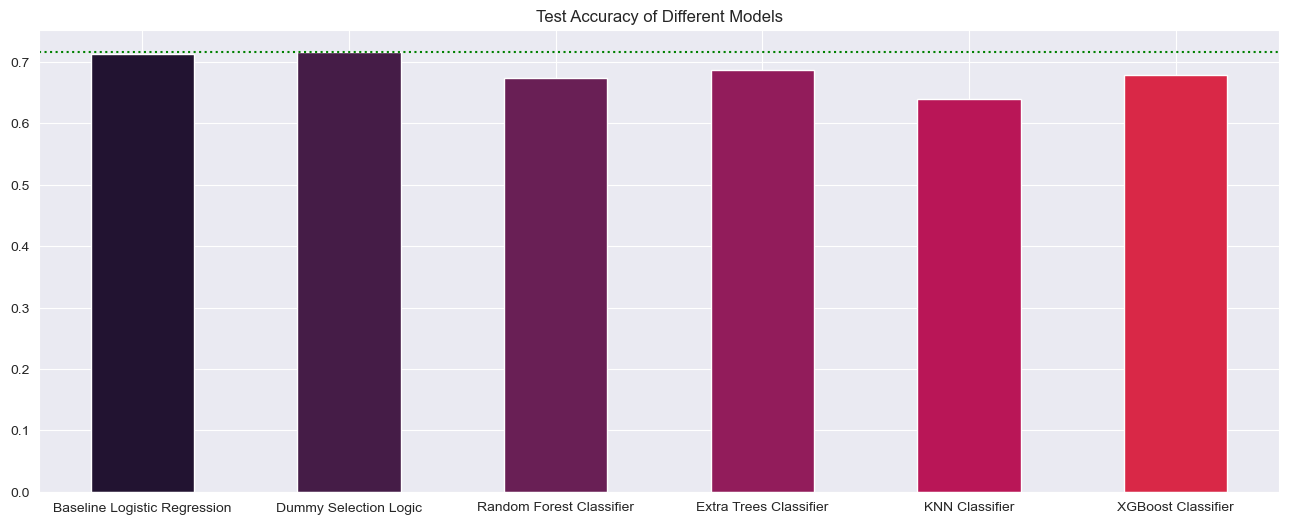

In [338]:
# Plotting Test Accuracy
fig, ax = plt.subplots(figsize = (16, 6))
pal = sns.color_palette("rocket", n_colors=10)
Model.model_df["test_accuracy"].plot(kind="bar", title="Test Accuracy of Different Models", color=pal)
ax.set_xticklabels(Model.model_df["name"], rotation = 0)
ax.axhline(Model.model_df.query("name == 'Dummy Selection Logic'")["test_accuracy"].values, \
           linestyle = ":", color="green")
plt.grid(True);

### Observations For These Models:
Again, I am consistently observing that the models use the respective Chalk Seeds as the most important feature. For the tree models, `Seeds are 3x more important` than the next feature on average. Also, XGBoost did not use the recent 10/5 game trends as a feature of importance, which is different than the other tree models. Given that none of these models have performed better than the dummy logic. I will have to attempt to adjust the features and target values in hopes of achieving better results. 

In [70]:
for i in range(3, 16, 2):
    pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', KNeighborsClassifier(n_neighbors=i))
])
    
    
    pipe_model.fit(X_train, y_train)
    filler = Model(f"KNN| N={i}", pipe_model, X_train, X_test, y_train, y_test)
    
Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
2,Random Forest Classifier,0.704837,0.716483,0.687693,0.700684,0.553453,0.692164,0.685714,0.713755,0.699454,0.567078,0.775768
3,Extra Trees Classifier,0.714798,0.721213,0.708765,0.714220,0.550605,0.679104,0.671378,0.706320,0.688406,0.569795,0.769294
5,XGBoost Classifier,0.715425,0.728680,0.695100,0.710133,0.702211,0.679104,0.673835,0.698885,0.686131,0.837950,0.760787
12,KNN| N=15,0.674333,0.684372,0.659213,0.669854,0.587776,0.669776,0.669118,0.676580,0.672828,0.649895,0.746592
10,KNN| N=11,0.676212,0.686002,0.659236,0.671238,0.636025,0.667910,0.669145,0.669145,0.669145,0.786707,0.735976
11,KNN| N=13,0.664993,0.672758,0.653033,0.661788,0.616326,0.666045,0.667910,0.665428,0.666667,0.654479,0.739986
9,KNN| N=9,0.674331,0.682854,0.657986,0.669700,0.741999,0.660448,0.652632,0.691450,0.671480,0.856465,0.726835
4,KNN Classifier,0.657528,0.660910,0.656759,0.658195,1.388824,0.639925,0.643939,0.631970,0.637899,1.968196,0.688644


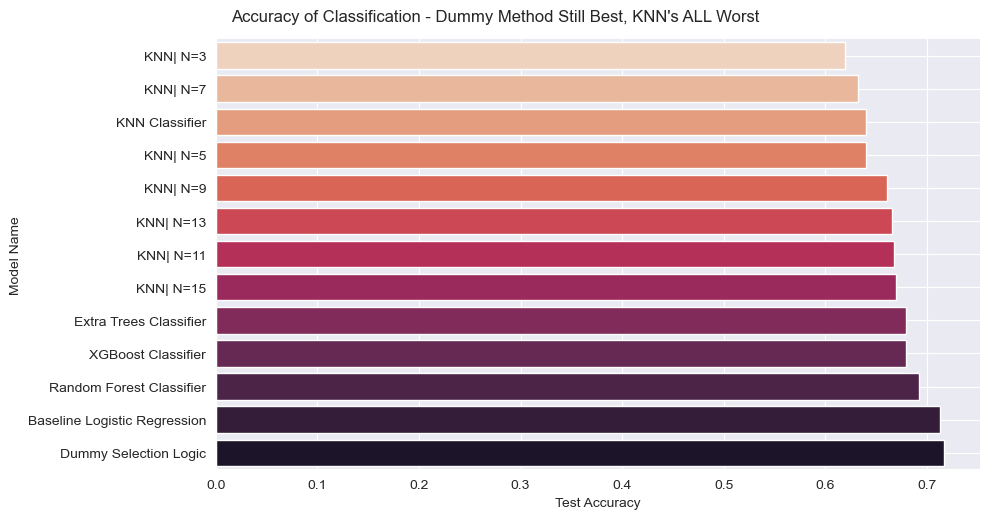

In [97]:
# Displaying the accuracies of different models so far

g = sns.catplot(data=Model.model_df.sort_values("test_accuracy"), x="test_accuracy", y='name', kind="bar", aspect=2,\
               palette="rocket_r")
g.fig.suptitle("Accuracy of Classification - Dummy Method Still Best, KNN's ALL Worst", y=1.03,)
g.set(xlabel="Test Accuracy", ylabel="Model Name")
plt.grid(True);

<hr style="border: 2px solid blue">

<div class= "alert alert-block alert-info" style = "font-size: 2em;">
<b>New Features:</b> Differences between Team_A and Team_B Statistics
</div>

Instead of using the single-team aggregated statistics, I will now consolidate the features from each respective team into a single column reflecting the difference between the two teams statistics. The only columns that will be exceptions are the categorical columns, such as conference or trend categories. I will perform the same train-test split on this new data with the same target value "y", and see if model performance improves at all. The predictions from dummy logic will remain the same, so comparisons will be made to previous models. 

In [213]:
# Create a new dataframe for the differenced data
diff_df = pd.DataFrame()

# Iterate through X to see if the column name starts with "Team_A" 
for i in X.select_dtypes(exclude="category").columns:
    if i[:7] == "Team_A_":
        # Capture the general statistic
        feature = i[7:]
        
        # Create new column in new 'X-like' dataframe
        diff_df[f"{feature}_diff"] = X[f"Team_A_{feature}"] - X[f"Team_B_{feature}"]
    
    
# Add the categorical features back to the data
diff_df = pd.concat([diff_df, X.select_dtypes(include="category")], axis=1)

In [217]:
# By consolidating columns, I reduced the features nearly by half

diff_df.shape, X.shape

((2142, 77), (2142, 145))

In [219]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(diff_df, y, random_state=13, test_size=.25, \
                                                    shuffle=True, stratify=y)

In [222]:
# Fitting a Logistic Regression Model to the Differenced Data

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', RandomForestClassifier())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f922b0fd4e0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f922b0fd4b0>)])),
                ('model', RandomForestClassifier())])

In [223]:
# diff_logreg = Model("LogReg - Diff Data", pipe_model, X_train, X_test, y_train, y_test)

# diff_rfc = Model("RFC - Diff Data", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
14,RFC - Diff Data,0.713543,0.712153,0.724837,0.717929,0.551059,0.707090,0.695804,0.739777,0.717117,0.571233,0.776966
13,LogReg - Diff Data,0.732859,0.731165,0.744690,0.737223,0.520316,0.705224,0.700361,0.721190,0.710623,0.528553,0.807123
2,Random Forest Classifier,0.704837,0.716483,0.687693,0.700684,0.553453,0.692164,0.685714,0.713755,0.699454,0.567078,0.775768
3,Extra Trees Classifier,0.714798,0.721213,0.708765,0.714220,0.550605,0.679104,0.671378,0.706320,0.688406,0.569795,0.769294
5,XGBoost Classifier,0.715425,0.728680,0.695100,0.710133,0.702211,0.679104,0.673835,0.698885,0.686131,0.837950,0.760787
12,KNN| N=15,0.674333,0.684372,0.659213,0.669854,0.587776,0.669776,0.669118,0.676580,0.672828,0.649895,0.746592
10,KNN| N=11,0.676212,0.686002,0.659236,0.671238,0.636025,0.667910,0.669145,0.669145,0.669145,0.786707,0.735976
11,KNN| N=13,0.664993,0.672758,0.653033,0.661788,0.616326,0.666045,0.667910,0.665428,0.666667,0.654479,0.739986


In [229]:
def compare_curves(list_of_models):
    """
    Function to compare the ROC curves of selected model objects
    
    Parameters
    -----------------
    list_of_models: list| this list contains instances of the custom Model class
    
    
    Returns
    -----------------
    figure: matplotlib.pyplot figure| plot of ROC curves for len(list_of_models) models
        useful for visual comparison of model performance.  
    """
    sns.set_style("dark")
    # Color Palette
    colors = sns.color_palette("Paired", n_colors=8)
    # Create the plot
    fig, ax = plt.subplots(figsize=(7,7))
    for i in range(len(list_of_models)):
        # get the predict_proba values
        y_hat_hd = list_of_models[i].y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(list_of_models[i].y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, color=colors[i], label=f'{list_of_models[i].name} | AUC: {list_of_models[i].auc:.2f})')

    ax.set_title(f"Comparison of ROC Curves")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    plt.grid(False);

In [2]:
# Inspecting the ROC curves 
compare_curves([diff_logreg, diff_rfc])

NameError: name 'compare_curves' is not defined